[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [HumanMessage(f"I'm researching ocean mammals.", name="Lance")]
messages.append(AIMessage(f"So you said you were researching ocean mammals?", name="Bot"))
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

I'm researching ocean mammals.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_aws import ChatBedrockConverse

# 1. CONFIGURACIÓN PARA DEEPSEEK-R1 (Razonamiento Complejo)
llm_deepseek_r1 = ChatBedrockConverse(
    model="us.deepseek.r1-v1:0",
    region_name="us-east-1",
    temperature=0.6,
    max_tokens=8192,
    top_p=0.95,
)

# 2. CONFIGURACIÓN PARA DEEPSEEK-V3
llm_deepseek_v3 = ChatBedrockConverse(
    model="us.deepseek.v3-v1:0",
    region_name="us-east-1",
    temperature=0.7,
    max_tokens=4096,
)

# 3. CONFIGURACIÓN PARA LLAMA 4 SCOUT
llm_scout = ChatBedrockConverse(
    model="us.meta.llama4-scout-17b-instruct-v1:0",
    region_name="us-east-1",
    temperature=0.5,
    max_tokens=2048,
    top_p=0.9,
)

# 4. CONFIGURACIÓN PARA LLAMA 4 MAVERICK
llm_maverick = ChatBedrockConverse(
    model="us.meta.llama4-maverick-17b-instruct-v1:0",
    region_name="us-east-1",
    temperature=0.5,
    max_tokens=2048,
    top_p=0.9,
)

# 5. CONFIGURACIÓN PARA AMAZON NOVA LITE
llm_nova_lite = ChatBedrockConverse(
    model="amazon.nova-lite-v1:0",
    region_name="us-east-1",
    temperature=0.5,
    max_tokens=2048,
    top_p=0.9,
)

# 6. CONFIGURACIÓN PARA AMAZON NOVA MICRO
llm_nova_micro = ChatBedrockConverse(
    model="amazon.nova-micro-v1:0",
    region_name="us-east-1",
    temperature=0.5,
    max_tokens=2048,
    top_p=0.9,
)

# 7. CONFIGURACIÓN PARA AMAZON NOVA PRO
llm_nova_pro = ChatBedrockConverse(
    model="amazon.nova-pro-v1:0",
    region_name="us-east-1",
    temperature=0.5,
    max_tokens=2048,
    top_p=0.9,
)

# Seleccionar el LLM activo
llm = llm_nova_micro
llm.invoke(messages)

/home/juansebas7ian/langchain-academy/lc-academy-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


AIMessage(content='There are many interesting ocean mammals to learn about. Here are some examples:\n\n* Dolphins\n* Porpoises\n* Sea Otters\n* Seals\n* Sea Lions\n* Manatees\n* Dugongs\n* Polar Bears\n* Walruses\n\nEach of these mammals has unique characteristics and behaviors that make them fascinating subjects of study. For instance, dolphins are known for their intelligence and complex social structures, while polar bears are adapted to the cold Arctic environment. Learning about these different species can provide insight into the diverse ways in which mammals have adapted to life in the ocean and other aquatic environments.', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '31c36ec9-4dc9-4fae-9faa-2c66324865ea', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 12 Jan 2026 23:55:40 GMT', 'content-type': 'application/json', 'content-length': '822', 'connection': 'keep-alive', 'x-amzn-requestid': '31c36ec9-4dc9-4fae-9faa-2c66324865ea'}, 'RetryAttempts'

We can run our chat model in a simple graph with `MessagesState`.

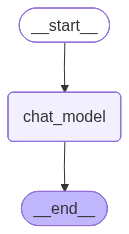

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

I'm researching ocean mammals.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many species of ocean mammals besides whales. Here are some notable examples:

### Dolphins
- **Family:** Delphinidae
- **Characteristics:** Known for their intelligence, playful behavior, and complex social structures.
- **Species:** Includes species like the bottlenose dolphin, killer whale (orca), and the pilot whale.

### Seals
- **Family:** Phocidae
- **Characteristics:** Typically found in colder waters; they are adept at diving and can remain underwater for extended periods

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

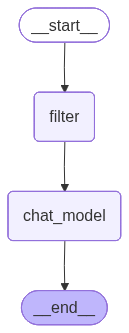

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-1]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [HumanMessage("Hello!", name="Lance", id="0")]
messages.append(AIMessage("Hi.", name="Bot", id="1"))
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

While whales are fascinating creatures, there are many other intriguing aspects of marine biology and ecology to explore. Here are some areas you might find equally captivating:

### Marine Mammals
1. **Dolphins and Porpoises**: Learn about their social structures, communication, and intelligence.
2. **Sea Otters**: Discover their unique hunting techniques and the threats they face.
3. **Seals and Sea Lions**: Explore their diverse habitats and behaviors.
4. **Pinnipeds**: Study the various species of seals and sea lions.
5. **Manatees and Dugongs**: Understand their roles in marine ecosystems and the challenges they face.

### Fish
1. **Reef Fish**: Dive into the diversity of species found in coral reefs.
2. **Deep-Sea Fish**: Learn about the adapta

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

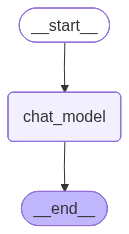

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hello!
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

While whales are fascinating creatures, there are many other intriguing aspects of marine biology and ecology to explore. Here are some areas you might find equally captivating:

### Marine Mammals
1. **Dolphins and Porpoises**: Learn about their social structures, communication, and intelligence.
2. **Sea Otters**: Discove

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hello!
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

While whales are fascinating creatures, there are many other intriguing aspects of marine biology and ecology to explore. Here are some areas you might find equally captivating:

### Marine Mammals
1. **Dolphins and Porpoises**: Learn about their social structures, communication, and intelligence.
2. **Sea Otters**: Discove

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://docs.langchain.com/oss/python/langgraph/add-memory#trim-messages), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

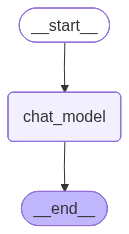

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=llm,
            allow_partial=False
        )

/home/juansebas7ian/langchain-academy/lc-academy-env/lib/python3.12/site-packages/langchain_core/language_models/base.py:328: UserWarning: Using fallback GPT-2 tokenizer for token counting. Token counts may be inaccurate for non-GPT-2 models. For accurate counts, use a model-specific method if available.
  return len(self.get_token_ids(text))


[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [18]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})
messages_out_trim

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, name='Lance', id='0'),
  AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3', tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='While whales are fascinating creatures, there are many other intriguing aspects of marine biology and ecology to explore. Here are some areas you might find equally captivating:\n\n### Marine Mammals\n1. **Dolphins and Porpoises**: Learn about their social structures, communication, and intelligence.\n2. **S

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r